In [1]:
import os
from datetime import timedelta


from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import seaborn as sns
import sklearn.preprocessing

#### Load Streamflow Data

In [2]:
paper_proj_dir = "/Users/mcarb/Documents/uno/2022_spring/thesis/\
repositories/streamflow_forcasting/DailyStreamflowForecastAutoReg"
paper_data_dir = os.path.join(paper_proj_dir, "time_series")

yx_ts_fname = "YangXianDailyFlow1997-2014.xlsx"
zjs_ts_fname = "ZhangJiaShanDailyFlow1997-2014.xlsx"

yx_ts_path = os.path.join(paper_proj_dir, paper_data_dir, yx_ts_fname)
zjs_ts_path = os.path.join(paper_proj_dir, paper_data_dir, zjs_ts_fname)

uploaded = files.upload()

Saving ZhangJiaShanRunoff1967-2017.xlsx to ZhangJiaShanRunoff1967-2017.xlsx
Saving ZhangJiaShanDailyFlow1997-2014.xlsx to ZhangJiaShanDailyFlow1997-2014.xlsx
Saving YangXianRunoff1967-2014.xlsx to YangXianRunoff1967-2014.xlsx
Saving YangXianDailyFlow1997-2014.xlsx to YangXianDailyFlow1997-2014.xlsx


### Explore Dataset

In [3]:
df = pd.read_excel(os.path.join("/content", yx_ts_fname))
df = df.iloc[:,0:2] 
df = df.set_index('TM')

# Verify that the index step is daily.
assert df.rolling('2D').count()[1:].min()[0] == 2

In [4]:
df.dtypes

DailyFlow    float64
dtype: object

### Prepare Dataset

In [5]:
np_arr = df.to_numpy().flatten()

In [6]:
sliding_window_view(np_arr, 11)

array([[60.1, 59.9, 56.8, ..., 45.7, 44.6, 46.1],
       [59.9, 56.8, 51. , ..., 44.6, 46.1, 47.8],
       [56.8, 51. , 49.3, ..., 46.1, 47.8, 47.3],
       ...,
       [70.3, 64.1, 77.3, ..., 66.4, 67.1, 63.5],
       [64.1, 77.3, 78.1, ..., 67.1, 63.5, 57.4],
       [77.3, 78.1, 86. , ..., 63.5, 57.4, 52.3]])

In [ ]:
df = df.reset_index(drop=True)

In [ ]:

def generate_time_series(df, pcts, batch_size, n_steps, steps_ahead):
    np_arr = df.to_numpy(dtype=np.float32)
    arr_len = len(np_arr)

    train_len = int(arr_len*pcts[0])
    test_len = int(arr_len*pcts[1])

    train = np_arr[:train_len]
    test = np_arr[train_len : train_len+test_len]
    val = np_arr[train_len+test_len:]
    
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train)
    
    train = scaler.transform(train)
    test = scaler.transform(test)
    val = scaler.transform(val)

    def helper(tensor):
      slice_ds = tf.data.Dataset.from_tensor_slices(tensor[1:])
      wdw_ds = slice_ds.window(steps_ahead, shift=1, drop_remainder=True)
      fmap_ds = wdw_ds.flat_map(lambda window: window.batch(steps_ahead, drop_remainder=True))
      map_ds = fmap_ds.map(lambda tensor: tf.reshape(tensor, [steps_ahead]))
      batch_ds = map_ds.batch(n_steps, drop_remainder=True)

      return batch_ds

    def create_ds(np_arr):
      slice_ds = tf.data.Dataset.from_tensor_slices(np_arr)
      wdw_ds = slice_ds.window(n_steps+steps_ahead, shift=1, drop_remainder=True)
      fmap_ds = wdw_ds.flat_map(
          lambda x: x.batch(n_steps+steps_ahead, drop_remainder=True))    
      batch_ds = fmap_ds.batch(batch_size, drop_remainder=True) 
      x_ds = batch_ds.map(lambda tensor: tensor[:, :n_steps, :])
      y_ds = fmap_ds.flat_map(helper).batch(batch_size, drop_remainder=True)
      zip_ds = tf.data.Dataset.zip((x_ds, y_ds))

      return zip_ds
    
    train_ds = create_ds(train)
    test_ds = create_ds(test)
    val_ds = create_ds(val)

    return train_ds, test_ds, val_ds, scaler



In [ ]:
train_ds, test_ds, val_ds, scaler = generate_time_series(df, (.70, .20), 32, 50, 10)

In [ ]:
i = 0
for e in train_ds:
  i+=1  
print(i)

141


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

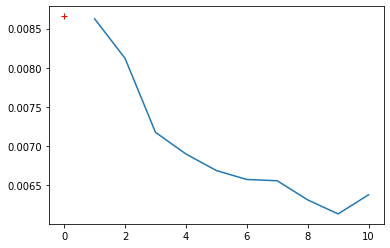

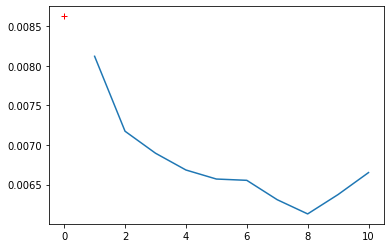

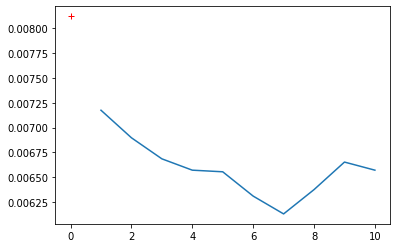

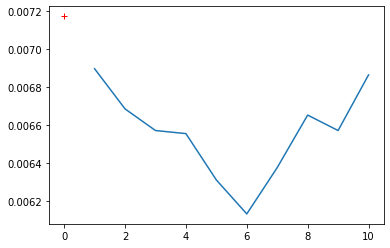

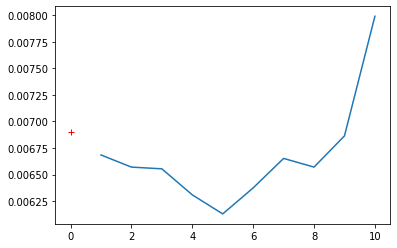

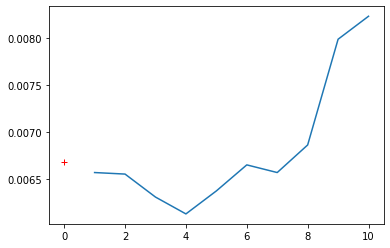

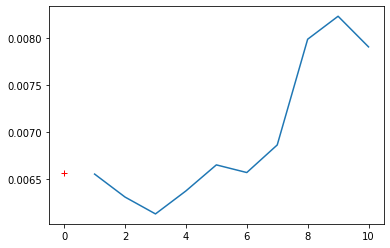

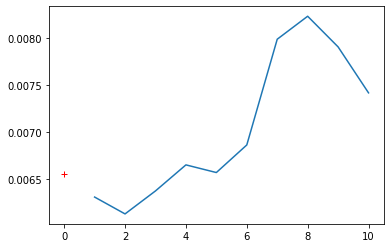

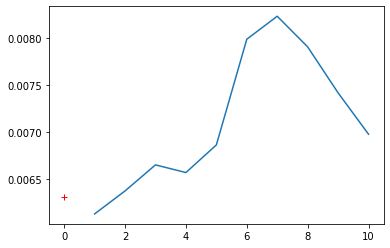

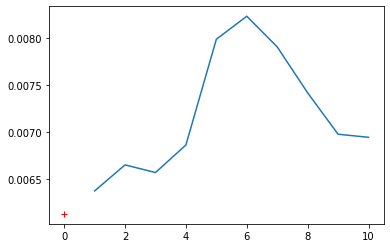

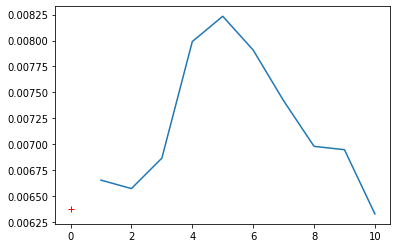

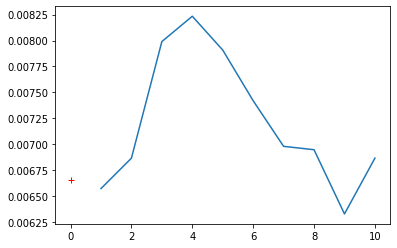

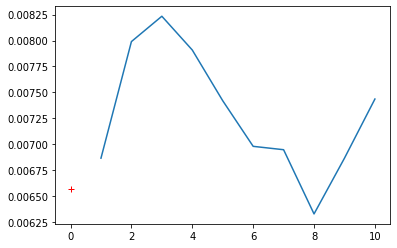

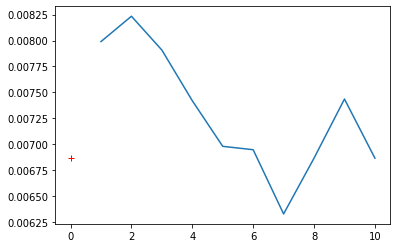

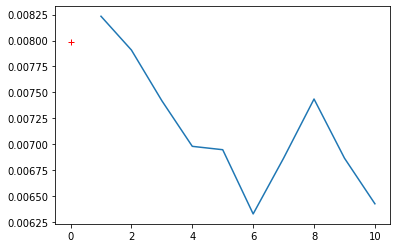

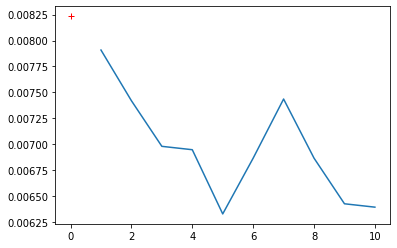

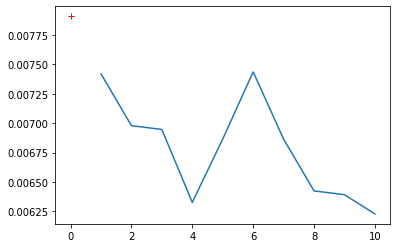

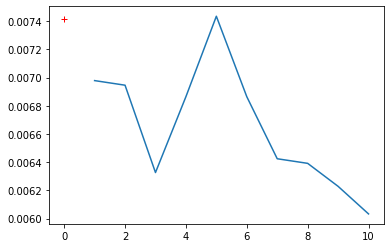

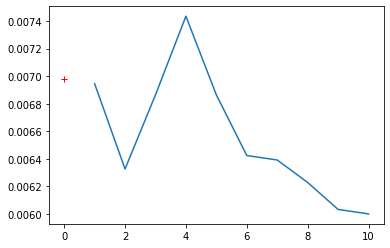

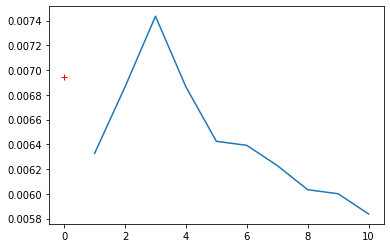

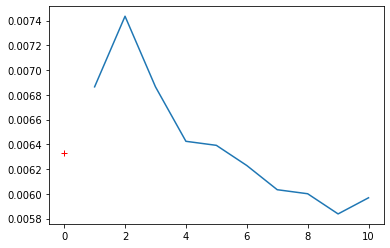

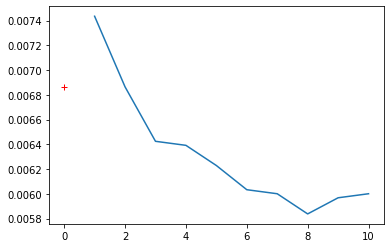

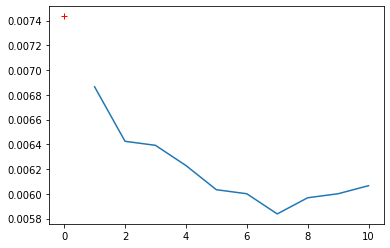

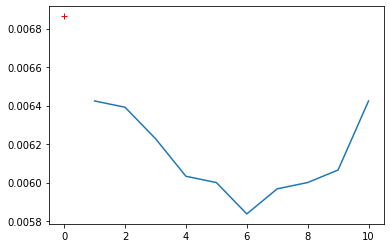

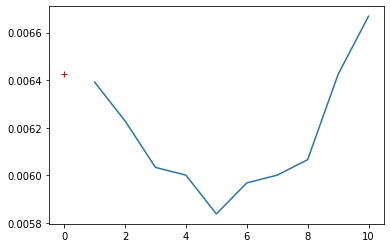

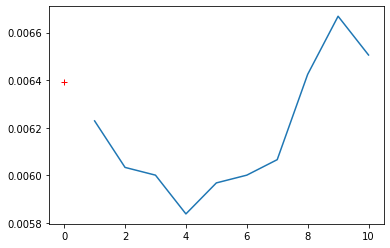

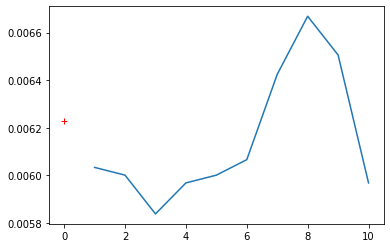

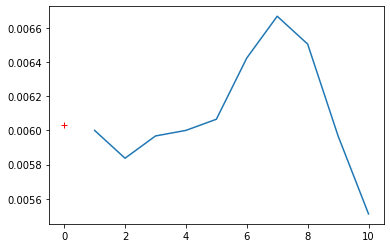

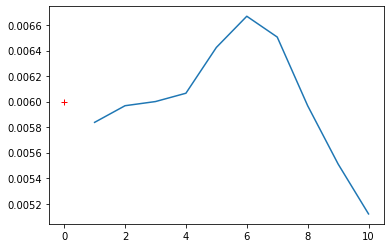

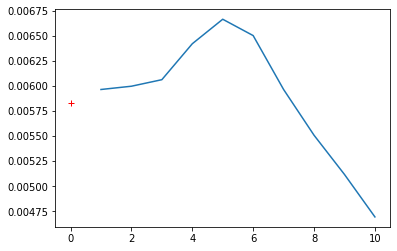

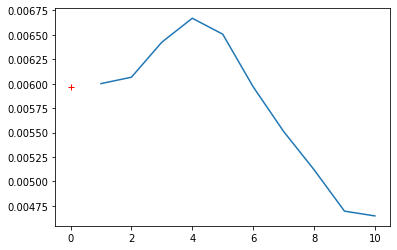

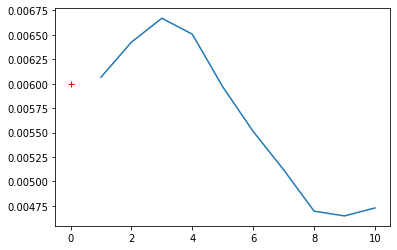

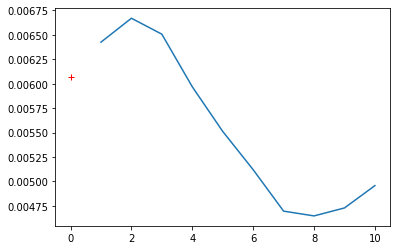

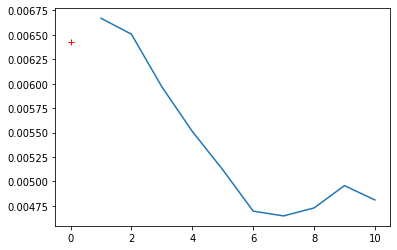

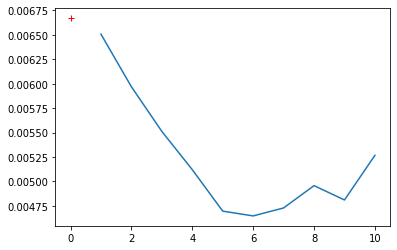

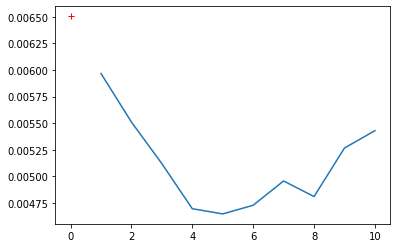

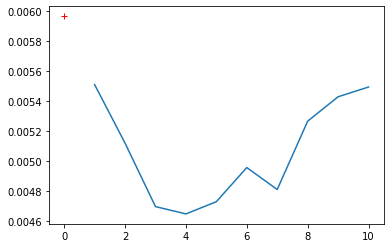

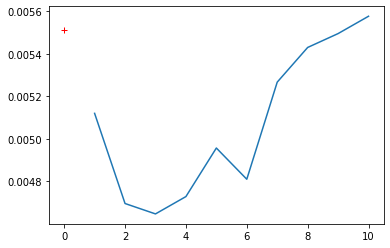

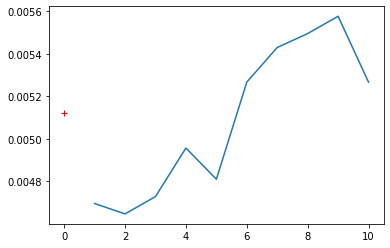

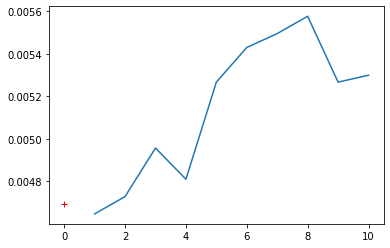

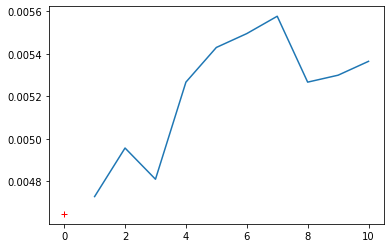

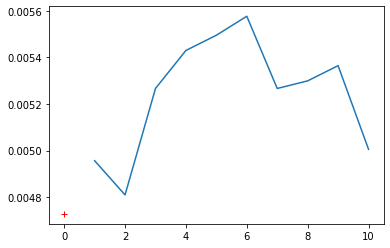

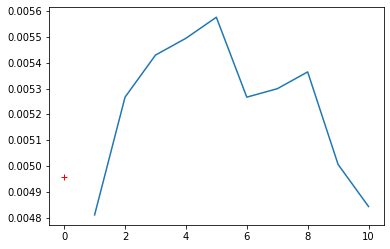

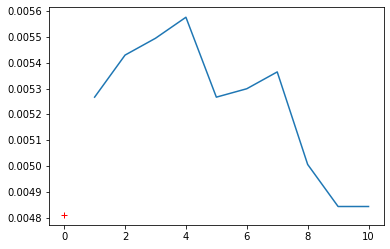

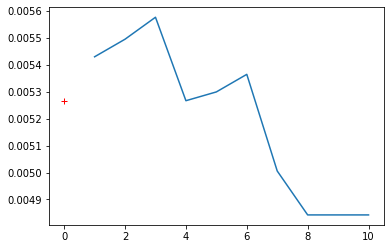

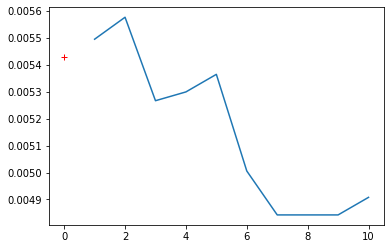

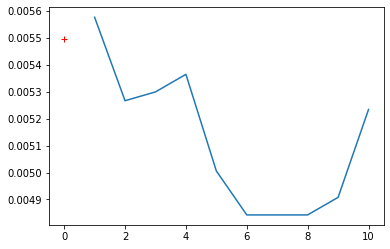

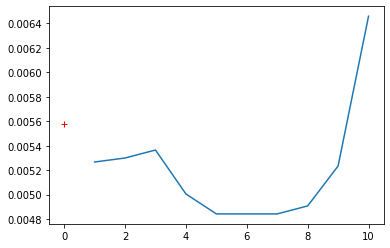

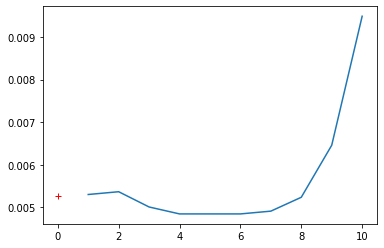

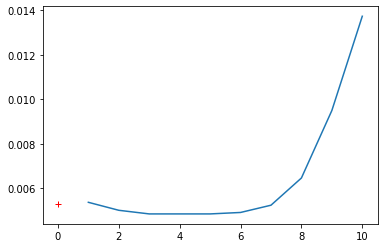

In [ ]:
features, labels = next(iter(train_ds))
features, labels = features[0], labels[0]

for i in range(len(list(features))):
  plt.figure()
  plt.plot(range(len(features[i])), features[i], 'r+', range(len(features[i]),len(features[i])+len(labels[i])), labels[i])
plt.show()

### Prepare Model

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate


In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 32)     96          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 64)     4160        ['conv1d[0][0]']                 
                                                                                                  
 gated_activation_unit (GatedAc  (None, None, 32)    0           ['conv1d_1[0][0]']               
 tivationUnit)                                                                                

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=.1), metrics=[last_time_step_mse])
history = model.fit(train_ds, epochs=1000,
                    validation_data=(val_ds))

Epoch 1/1000
141/141 [==============================] - 35s 238ms/step - loss: 0.0086 - last_time_step_mse: 0.0086 - val_loss: 0.0082 - val_last_time_step_mse: 0.0081
Epoch 2/1000
141/141 [==============================] - 33s 232ms/step - loss: 0.0086 - last_time_step_mse: 0.0085 - val_loss: 0.0082 - val_last_time_step_mse: 0.0081
Epoch 3/1000
141/141 [==============================] - 31s 223ms/step - loss: 0.0086 - last_time_step_mse: 0.0085 - val_loss: 0.0082 - val_last_time_step_mse: 0.0081
Epoch 4/1000
141/141 [==============================] - 31s 223ms/step - loss: 0.0086 - last_time_step_mse: 0.0085 - val_loss: 0.0082 - val_last_time_step_mse: 0.0081
Epoch 5/1000
141/141 [==============================] - 32s 229ms/step - loss: 0.0086 - last_time_step_mse: 0.0085 - val_loss: 0.0082 - val_last_time_step_mse: 0.0081
Epoch 6/1000
 17/141 [==>...........................] - ETA: 27s - loss: 0.0100 - last_time_step_mse: 0.0109

KeyboardInterrupt: ignored

In [ ]:
type(train_ds)
for ds in train_ds.take(1):
  print(ds)

(<tf.Tensor: shape=(32, 50, 1), dtype=float32, numpy=
array([[[0.00865808],
        [0.00862547],
        [0.00812001],
        ...,
        [0.00557639],
        [0.00526659],
        [0.0052992 ]],

       [[0.00862547],
        [0.00812001],
        [0.0071743 ],
        ...,
        [0.00526659],
        [0.0052992 ],
        [0.00536442]],

       [[0.00812001],
        [0.0071743 ],
        [0.00689711],
        ...,
        [0.0052992 ],
        [0.00536442],
        [0.00500571]],

       ...,

       [[0.00583727],
        [0.00596771],
        [0.00600033],
        ...,
        [0.0208707 ],
        [0.01858797],
        [0.01679439]],

       [[0.00596771],
        [0.00600033],
        [0.00606555],
        ...,
        [0.01858797],
        [0.01679439],
        [0.01581608]],

       [[0.00600033],
        [0.00606555],
        [0.00642426],
        ...,
        [0.01679439],
        [0.01581608],
        [0.01532692]]], dtype=float32)>, <tf.Tensor: shape=(32, 50, 10), dt